# Lab 2 - Radial basis functions, competitive learning and self-organisation

## Import libraries


In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# Assignement : Part 1

## Building the RBF Network


In [2]:
class RBFNet():
    def __init__(self, centers, sigmas, input_dim = 1, output_dim = 1):
        # dimensions
        self.input_dim = input_dim
        self.hidden_dim = centers.shape[0]
        self.output_dim = output_dim

        # hyperparemeters
        self.centers = centers
        self.sigmas = sigmas

        # parameters of training
        self.w = torch.zeros(self.output_dim, self.hidden_dim)
        self.loss_train = []
        self.loss_val = []

    # Kernel using gaussian RBF
    def phi(self, x):
        if x.dim() == 0 :
            N = 1
        else :
            N = x.shape[0]

        # Creating matrix operation friendly variables
        matrix = x.view(1, -1).expand(self.hidden_dim, -1).T 
        centers = self.centers.view(1, -1).expand(N, -1)
        sigmas = self.sigmas.view(1, -1).expand(N, -1)

        return torch.exp(-torch.pow(matrix-centers,2) /(2*torch.pow(sigmas,2)))

    
    # MSE loss
    def loss(self, y_pred, y):
        y = y.view_as(y_pred)
        return torch.mean((y-y_pred)**2)
    
    def get_std(self, y_pred, y) :
        y = y.view_as(y_pred)
        return torch.std(y_pred-y)
    
    # Residual value
    def residual_value(self, y_pred, y) :
        y = y.view_as(y_pred)
        return torch.mean(torch.abs(y_pred - y))
    
    # Forward method
    def forward(self, x):
        return self.phi(x) @ self.w.T
    
    # 1. Training method : least squares
    def least_squares_train(self, X_train, Y_train):
        start_time = time.time()

        # resetting the value of the weights
        self.w = torch.zeros(self.output_dim, self.hidden_dim)

        phi_matrix = self.phi(X_train)
        self.w = (torch.inverse(phi_matrix.T @ phi_matrix)) @ (Y_train @ phi_matrix)

        end_time = time.time()
        print("Training time : ", end_time - start_time)
        return self.w

    ### Shuffling of the data
    def shuffle_dataset(self, X, Y):
        indices = torch.randperm(X.shape[0])
        shuffled_X = X[indices]
        shuffled_Y = Y[indices]
        return shuffled_X, shuffled_Y

    ### Update rule
    def delta_rule(self, x, y, lr): 
        y_pred = self.forward(x)
        phi_data = self.phi(x)
        self.w = self.w + lr * (y - y_pred) * phi_data
        return self.w.reshape(1, -1)
    
    # 2. Training method : delta rule
    def delta_train(self, X_train, Y_train, lr, epochs):
        # resetting the vlues of the weights
        self.w = torch.randn(self.output_dim, self.hidden_dim)
        self.loss_train = []
        
        for epoch in range(epochs):
            # shuffling data
            X, Y = self.shuffle_dataset(X_train, Y_train)

            for i in range(X.shape[0]):
                self.delta_rule(X[i], Y[i], lr)

            self.loss_train.append(self.loss(self.forward(X), Y))
                    
        return self.w, self.loss_train
    
    def predict(self, x):
        return self.forward(x)
    



## Batch mode training using least squares

### Function approximation using batch learning


In [3]:
# Functions to estimate
def sin2(x):
    return torch.sin(2*x)


def square(x):
    return torch.sign(torch.sin(2*x))


def classify(x):
    return torch.sign(x)

### Building free noise dataset

In [4]:
# Building datasets
step = 0.1

X_train = torch.arange(0, 2*np.pi, step)
sin_Y_train = sin2(X_train)
square_Y_train = square(X_train)

X_test = torch.arange(0.05, 2*np.pi, step)
sin_Y_test = sin2(X_test)
square_Y_test = square(X_test)

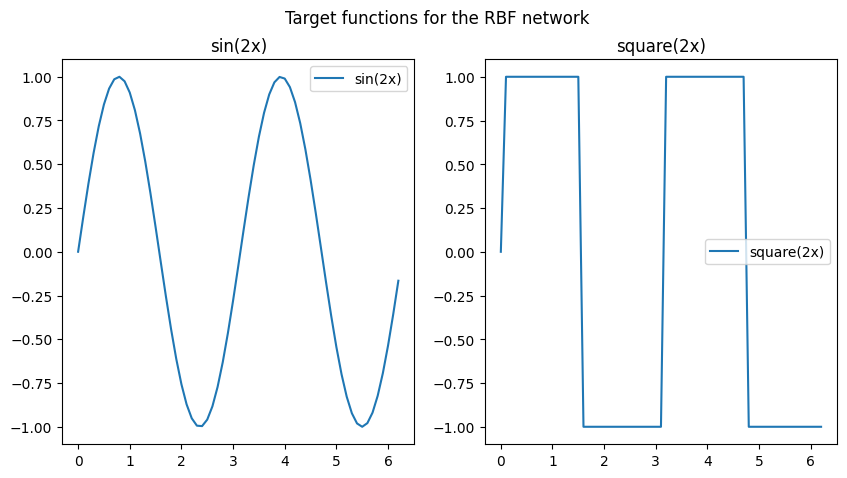

In [5]:
# Plot datasets
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Target functions for the RBF network")

# Plot sin(2x) dataset
ax[0].plot(X_train, sin_Y_train, label='sin(2x)')
ax[0].set_title("sin(2x)")
ax[0].legend()

# Plot square(2x) dataset
ax[1].plot(X_train, square_Y_train, label='square(2x)')
ax[1].set_title("square(2x)")
ax[1].legend()

plt.show()

### Functions to train the model for both functions

In [6]:
# Function that allows to train for the two target functions and return key results
def train_ls_target(X_train, sin_Y_train, square_Y_train, X_test, centers_nb, sigma_value):
    # Generate centers
    centers = torch.linspace(0, 2*np.pi, centers_nb)
    sigmas = torch.tensor([sigma_value]*centers.shape[0])

    # Training the models
    # Model that approximates sin(2x)
    sin_model = RBFNet(centers, sigmas)
    sin_weights = sin_model.least_squares_train(X_train, sin_Y_train)

    # Model that approximates square(2x)
    square_model = RBFNet(centers, sigmas)
    square_weights = square_model.least_squares_train(X_train, square_Y_train)

    # Predict
    sin_Y_pred = sin_model.predict(X_test)
    square_Y_pred = square_model.predict(X_test)

    return sin_model, sin_weights, sin_Y_pred, square_model, square_weights, square_Y_pred

# Function that allows to train for the two target functions and return key results


def train_delta_target(X_train, sin_Y_train, square_Y_train, X_test, centers_nb, sigma_value, lr=0.01, nb_epochs=50):
    # Generate centers
    centers = torch.linspace(0, 2*np.pi, centers_nb)
    
    sigmas = torch.tensor([sigma_value]*centers.shape[0])

    # Training the models
    # Model that approximates sin(2x)
    sin_model = RBFNet(centers, sigmas)
    sin_weights, sin_loss = sin_model.delta_train(
        X_train, sin_Y_train, lr, nb_epochs)

    # Model that approximates square(2x)
    square_model = RBFNet(centers, sigmas)
    square_weights, square_loss = square_model.delta_train(
        X_train, square_Y_train, lr, nb_epochs)

    # Predict
    sin_Y_pred = sin_model.predict(X_test)
    square_Y_pred = square_model.predict(X_test)

    return sin_model, sin_weights, torch.tensor(sin_loss), sin_Y_pred, square_model, square_weights, torch.tensor(square_loss), square_Y_pred

### Finding number of nodes to optimize the error

In [7]:
# Finding the appropriate number of center given the wanted error
sigma_value = 0.1
centers_nb_list = [i for i in range(1, X_train.shape[0])]
errors = [0.1, 0.01, 0.001, 0]

# smallest nb of centers that give an error below the one wanted above
sin_center_nb_values = []
square_center_nb_values = []

sin_j = 0
square_j = 0

for centers_nb in centers_nb_list:
    sin_ls_model, sin_ls_weights, sin_ls_Y_pred, square_ls_model, square_ls_weights, square_ls_Y_pred = train_ls_target(
        X_train, sin_Y_train, square_Y_train, X_test, centers_nb, sigma_value)
    if sin_j < len(errors) and sin_ls_model.residual_value(sin_ls_Y_pred, sin_Y_test) < errors[sin_j]:
        sin_center_nb_values.append(centers_nb)
        sin_j += 1
    if square_j < len(errors) and square_ls_model.residual_value(classify(square_ls_Y_pred), square_Y_test) < errors[square_j]:
        square_center_nb_values.append(centers_nb)
        square_j += 1

print("Batch minimum number of nodes for 0.1, 0.01, 0.001 residual error : ", sin_center_nb_values, square_center_nb_values)

Training time :  0.0024569034576416016
Training time :  0.00013518333435058594
Training time :  0.0001361370086669922
Training time :  8.273124694824219e-05
Training time :  0.00015616416931152344
Training time :  0.00012421607971191406
Training time :  6.723403930664062e-05
Training time :  4.601478576660156e-05
Training time :  6.580352783203125e-05
Training time :  4.38690185546875e-05
Training time :  4.00543212890625e-05
Training time :  3.790855407714844e-05
Training time :  3.814697265625e-05
Training time :  3.719329833984375e-05
Training time :  7.867813110351562e-05
Training time :  4.9114227294921875e-05
Training time :  4.482269287109375e-05
Training time :  4.076957702636719e-05
Training time :  4.410743713378906e-05
Training time :  4.029273986816406e-05
Training time :  4.1961669921875e-05
Training time :  3.981590270996094e-05
Training time :  3.910064697265625e-05
Training time :  3.790855407714844e-05
Training time :  4.100799560546875e-05
Training time :  3.886222839

/var/folders/76/ktnqnwjn3kz2zdhpgy_03fww0000gn/T/ipykernel_5807/671686184.py:48: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  return self.phi(x) @ self.w.T


### Displaying predictions on examples

In [8]:
# Set parameters
sigma_value = 0.1
centers_nb = 45

sin_ls_model, sin_ls_weights, sin_ls_Y_pred, square_ls_model, square_ls_weights, square_ls_Y_pred = train_ls_target(
    X_train, sin_Y_train, square_Y_train, X_test, centers_nb, sigma_value)

Training time :  0.0007698535919189453
Training time :  0.00022912025451660156


In [9]:
def plot_predictions(X_test, Y_test_list, Y_pred_list, titles, suptitle, centers_nb, sigmas = 0):

    if type(centers_nb) == int :
        graphs = len(Y_pred_list)

        # Plot predictions
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        fig.suptitle(suptitle + f"\n {centers_nb} nodes")

        for i in range(len(Y_pred_list)):
            ax[i].plot(X_test, Y_test_list[i], label='Actual')
            ax[i].plot(X_test, Y_pred_list[i], label='Predicted')
            ax[i].set_title(titles[i])
            ax[i].legend()

        plt.show()
    else :
        # Plot predictions
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))

        fig.suptitle(suptitle)

        for i in range(len(Y_pred_list)):
            ax[i].plot(X_test, Y_test_list[i], label='Actual')
            ax[i].plot(X_test, Y_pred_list[i], label='Predicted')
            ax[i].set_title(titles[i] + f" - {centers_nb[i]} nodes")
            ax[i].legend()

        plt.show()

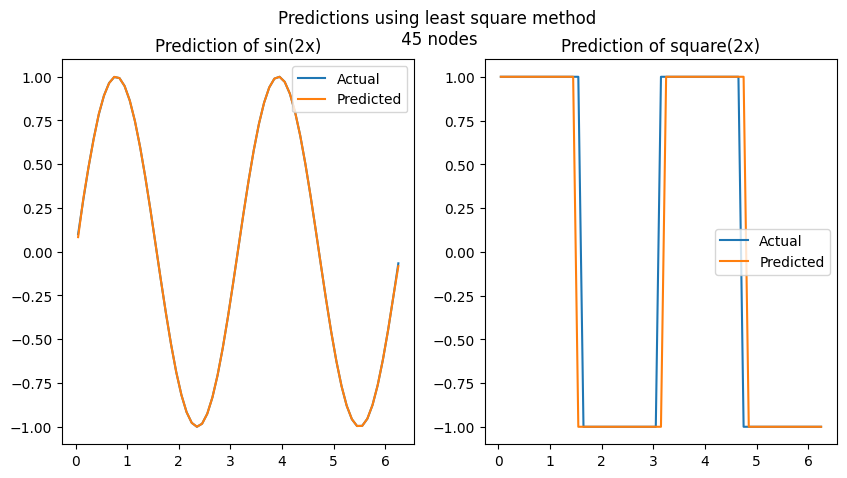

In [10]:
plot_predictions(X_test, [sin_Y_test, square_Y_test], [sin_ls_Y_pred, classify(square_ls_Y_pred)], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions using least square method", centers_nb)

### Computing test error for both target functions

In [11]:
# Calculate residual value for sin function
sin_residual = sin_ls_model.residual_value(sin_ls_Y_pred, sin_Y_test)
print("Residual value for sin function:", sin_residual)

# Calculate residual value for square function
square_residual = square_ls_model.residual_value(
    classify(square_ls_Y_pred), classify(square_Y_test))
print("Residual value for square function:", square_residual)

Residual value for sin function: tensor(0.0010)
Residual value for square function: tensor(0.0952)


### Displaying weight values

In [12]:
def plot_weights(weight_list, titles, suptitle):

    fig, ax = plt.subplots(1, len(weight_list), figsize=(10, 5))

    fig.suptitle(suptitle)

    for i in range(len(weight_list)):
        ax[i].bar(range(len(weight_list[i])), weight_list[i])
        ax[i].set_title(titles[i])

    plt.show()

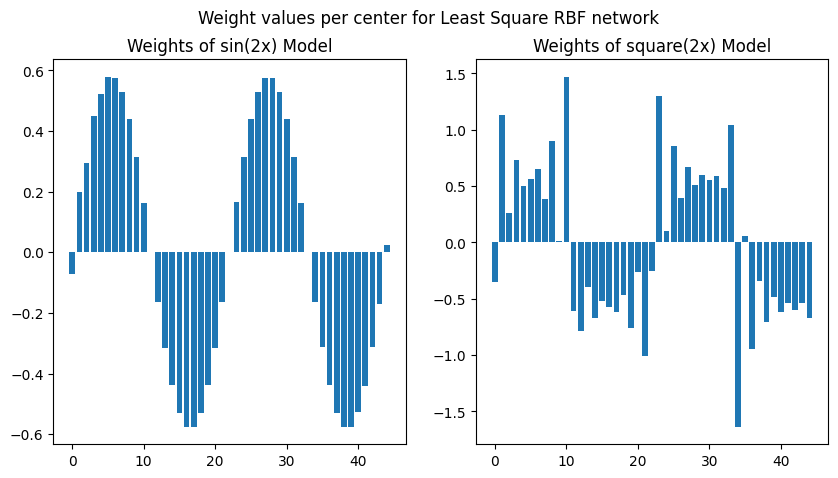

In [13]:
plot_weights([sin_ls_weights, square_ls_weights], ["Weights of sin(2x) Model",
             "Weights of square(2x) Model"], "Weight values per center for Least Square RBF network")

**Note :** Intersting when `centers = X_train`, as we almost recove the sinusoidal function. It makes sens as the centers whose value is close to 1 or -1 must discriminate more ina classification problem, so the associated weight must be higher.


## Regression with noise - delta rule and online learning


### Building noised dataset

In [14]:
# Adding noise to the data
data_var = 0.1
data_std = np.sqrt(data_var)

# Building datasets
step = 0.1

X_train = torch.arange(0, 2*np.pi, step)
noised_sin_Y_train = sin2(X_train) + torch.normal(0, data_std, X_train.shape)
noised_square_Y_train = square(
    X_train) + torch.normal(0, data_std, X_train.shape)

X_test = torch.arange(0.05, 2*np.pi, step)
noised_sin_Y_test = sin2(X_test) + torch.normal(0, data_std, X_test.shape)
noised_square_Y_test = square(X_test) + torch.normal(0, data_std, X_test.shape)

### Best node number on noised data
Grid search on the sigma value and the number of nodes

In [15]:
"""# Finding the appropriate number of center given the wanted error
sigma_value = [0.05 + 0.01*k for k in range(10)]
centers_nb_list = [i for i in range(35, 50, 10)]

best_sigma_sin = 0.1
best_center_nb_sin = 1
min_loss_sin = 200

best_sigma_square = 0.1
best_center_nb_square = 1
min_loss_square = 200

# Parameters
lr = 0.05
epochs = 50

# smallest nb of centers that give an error below the one wanted above
sin_center_nb_values = []
square_center_nb_values = []

for sigma in sigma_value :
    for centers_nb in centers_nb_list:
        print(sigma, lr, epochs, centers_nb)
        sin_delta_model, sin_delta_weights, sin_delta_loss, noised_sin_delta_Y_pred, square_delta_model, square_delta_weights, square_delta_loss, noised_square_delta_Y_pred = train_delta_target(
        X_train, noised_sin_Y_train, noised_square_Y_train, X_test, centers_nb, sigma, lr, epochs)
        if sin_delta_model.loss(noised_sin_delta_Y_pred, noised_sin_Y_test) < min_loss_sin :
            min_loss_sin = sin_delta_model.loss(noised_sin_delta_Y_pred, noised_sin_Y_test)
            best_sigma_sin = sigma
            best_center_nb_sin = centers_nb
        if square_delta_model.loss(noised_square_delta_Y_pred, noised_square_Y_test) < min_loss_square :
            min_loss_square = square_delta_model.loss(noised_square_delta_Y_pred, noised_square_Y_test)
            best_sigma_square = sigma
            best_center_nb_square = centers_nb



print("Sin target : sigma = ", best_sigma_sin, " nb of centers = ", best_center_nb_sin)
print("Square target : sigma = ", best_sigma_square, " nb of centers = ", best_center_nb_square)"""

'# Finding the appropriate number of center given the wanted error\nsigma_value = [0.05 + 0.01*k for k in range(10)]\ncenters_nb_list = [i for i in range(35, 50, 10)]\n\nbest_sigma_sin = 0.1\nbest_center_nb_sin = 1\nmin_loss_sin = 200\n\nbest_sigma_square = 0.1\nbest_center_nb_square = 1\nmin_loss_square = 200\n\n# Parameters\nlr = 0.05\nepochs = 50\n\n# smallest nb of centers that give an error below the one wanted above\nsin_center_nb_values = []\nsquare_center_nb_values = []\n\nfor sigma in sigma_value :\n    for centers_nb in centers_nb_list:\n        print(sigma, lr, epochs, centers_nb)\n        sin_delta_model, sin_delta_weights, sin_delta_loss, noised_sin_delta_Y_pred, square_delta_model, square_delta_weights, square_delta_loss, noised_square_delta_Y_pred = train_delta_target(\n        X_train, noised_sin_Y_train, noised_square_Y_train, X_test, centers_nb, sigma, lr, epochs)\n        if sin_delta_model.loss(noised_sin_delta_Y_pred, noised_sin_Y_test) < min_loss_sin :\n          

In [16]:
best_sigma_sin = 0.5
best_center_nb_sin = 37

best_sigma_square = 0.07
best_center_nb_square = 45

### Showing predictions on examples

In [17]:
# Set parameters
sigma_value_delta = 0.5
lr = 0.05
epochs = 50
centers_nb = 10

sigma_value_ls = 0.1

# Training the models
sin_delta_model, sin_delta_weights, sin_delta_loss, noised_sin_delta_Y_pred, square_delta_model, square_delta_weights, square_delta_loss, noised_square_delta_Y_pred = train_delta_target(
    X_train, noised_sin_Y_train, noised_square_Y_train, X_test, centers_nb, sigma_value_delta, lr, epochs)
sin_noised_ls_model, sin_noised_ls_weights, noised_sin_ls_Y_pred, square_noised_ls_model, square_noised_ls_weights, noised_square_ls_Y_pred = train_ls_target(
    X_train, noised_sin_Y_train, noised_square_Y_train, X_test, centers_nb, sigma_value_ls)

Training time :  0.00013375282287597656
Training time :  0.0002880096435546875


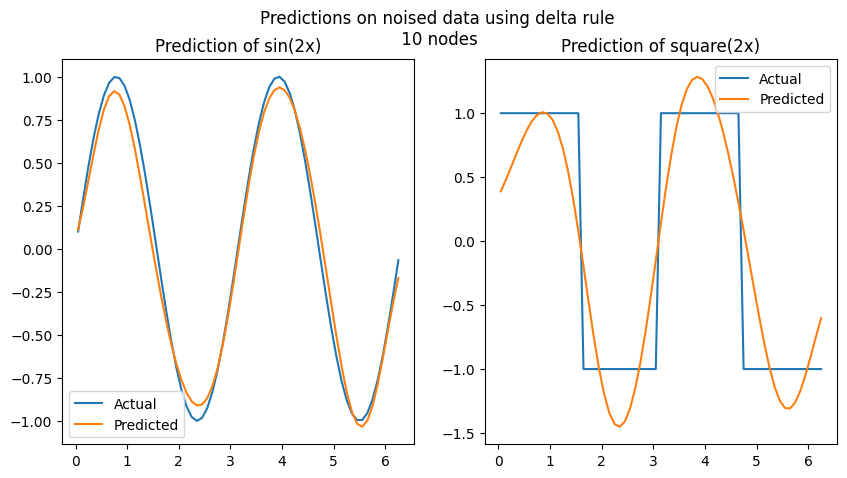

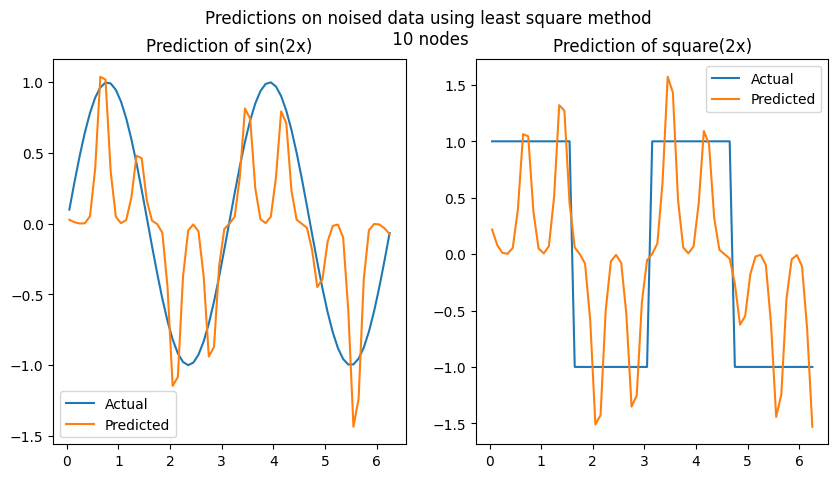

In [18]:
# Predictions using delta rule on noised data
plot_predictions(X_test, [sin_Y_test, square_Y_test], [noised_sin_delta_Y_pred, noised_square_delta_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using delta rule", centers_nb)

# Predictions using least square methods on noised data
plot_predictions(X_test, [sin_Y_test, square_Y_test], [noised_sin_ls_Y_pred, noised_square_ls_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using least square method", centers_nb)

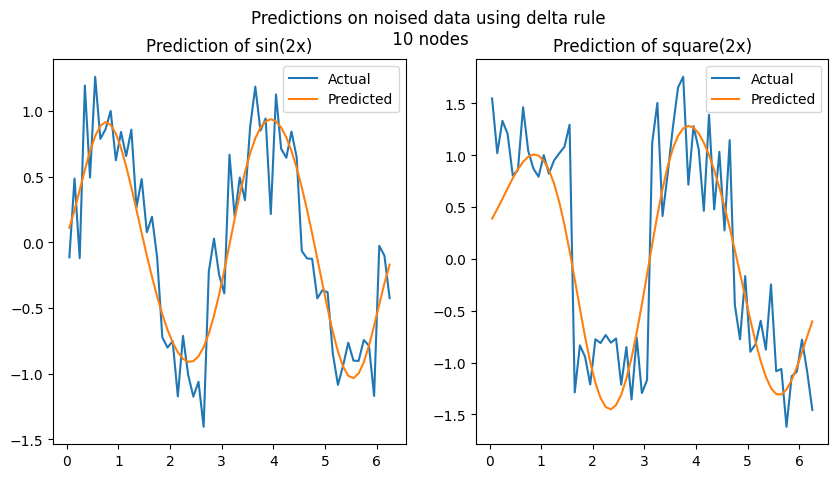

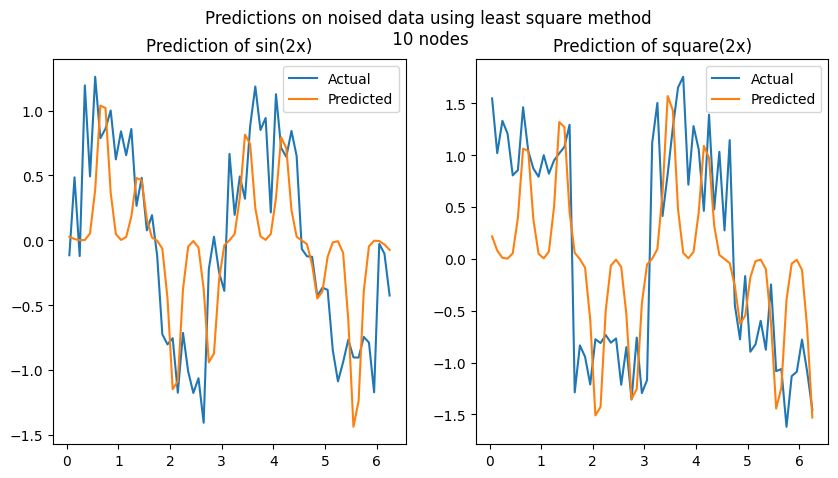

In [19]:
# Predictions using delta rule on noised data
plot_predictions(X_test, [noised_sin_Y_test, noised_square_Y_test], [noised_sin_delta_Y_pred, noised_square_delta_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using delta rule", centers_nb)

# Predictions using least square methods on noised data
plot_predictions(X_test, [noised_sin_Y_test, noised_square_Y_test], [noised_sin_ls_Y_pred, noised_square_ls_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using least square method", centers_nb)

**Delta rule :** sigma acts like a regularizer. Increasing it makes the predictio smoother, decreasing makes the prediction more sensitive to the noise.
Let's take a look at the loss function :


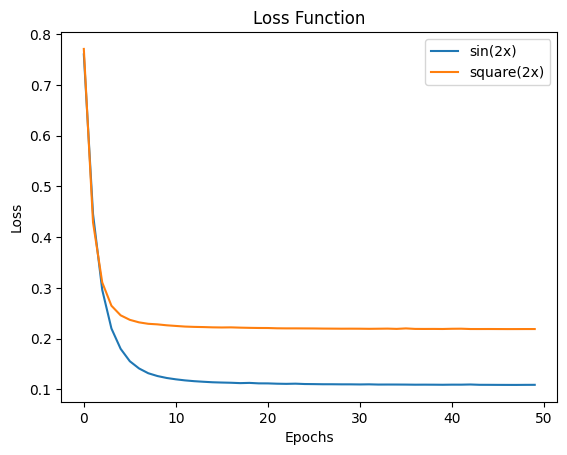

In [20]:
# Plotting the loss function
plt.plot(sin_delta_loss, label='sin(2x)')
plt.plot(square_delta_loss, label='square(2x)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.legend()
plt.show()

### Computing test error for both methods

In [21]:
# Calculate test loss for sin function using delta rule
sin_delta_test_loss = sin_delta_model.loss(noised_sin_delta_Y_pred, noised_sin_Y_test)
print("Test loss for sin function using delta rule:", sin_delta_test_loss.item())

# Calculate test loss for square function using delta rule
square_delta_test_loss = square_delta_model.loss(noised_square_delta_Y_pred, noised_square_Y_test)
print("Test loss for square function using delta rule:", square_delta_test_loss.item())

# Calculate test loss for sin function using least square method
sin_ls_test_loss = sin_noised_ls_model.loss(noised_sin_ls_Y_pred, noised_sin_Y_test)
print("Test loss for sin function using least square method:", sin_ls_test_loss.item())

# Calculate test loss for square function using least square method
square_ls_test_loss = square_noised_ls_model.loss(noised_square_ls_Y_pred, noised_square_Y_test)
print("Test loss for square function using least square method:", square_ls_test_loss.item())



Test loss for sin function using delta rule: 0.09216313064098358
Test loss for square function using delta rule: 0.28823503851890564
Test loss for sin function using least square method: 0.3429943025112152
Test loss for square function using least square method: 0.6381152272224426


### Computing standard deviation on the test sets

In [22]:
# Get the standard deviation of the Delta Rule model
sin_delta_std = sin_delta_loss.std().item()
square_delta_std = square_delta_loss.std().item()

# Printing the results
print("Standard Deviation of Least Square Model (sin(2x)): ", sin_noised_ls_model.get_std(noised_sin_ls_Y_pred, noised_sin_Y_test).item())
print("Standard Deviation of Least Square Model (square(2x)): ", square_noised_ls_model.get_std(noised_square_ls_Y_pred, noised_square_Y_test).item())
print("Standard Deviation of Delta Rule Model (sin(2x)): ", sin_delta_std)
print("Standard Deviation of Delta Rule Model (square(2x)): ", square_delta_std)

Standard Deviation of Least Square Model (sin(2x)):  0.5896231532096863
Standard Deviation of Least Square Model (square(2x)):  0.7993769645690918
Standard Deviation of Delta Rule Model (sin(2x)):  0.10551432520151138
Standard Deviation of Delta Rule Model (square(2x)):  0.0832645371556282


## Comparing BRF network to MLP single-hidden-layer network


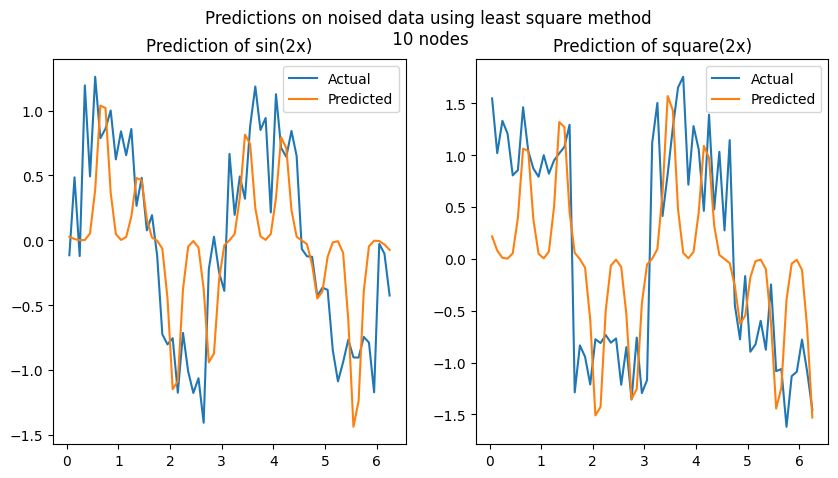

100%|██████████| 50/50 [00:00<00:00, 1259.88it/s]


Time to train sin(2x) model:  0.05063295364379883


100%|██████████| 50/50 [00:00<00:00, 3220.64it/s]


Time to train square(2x) model:  0.01645183563232422


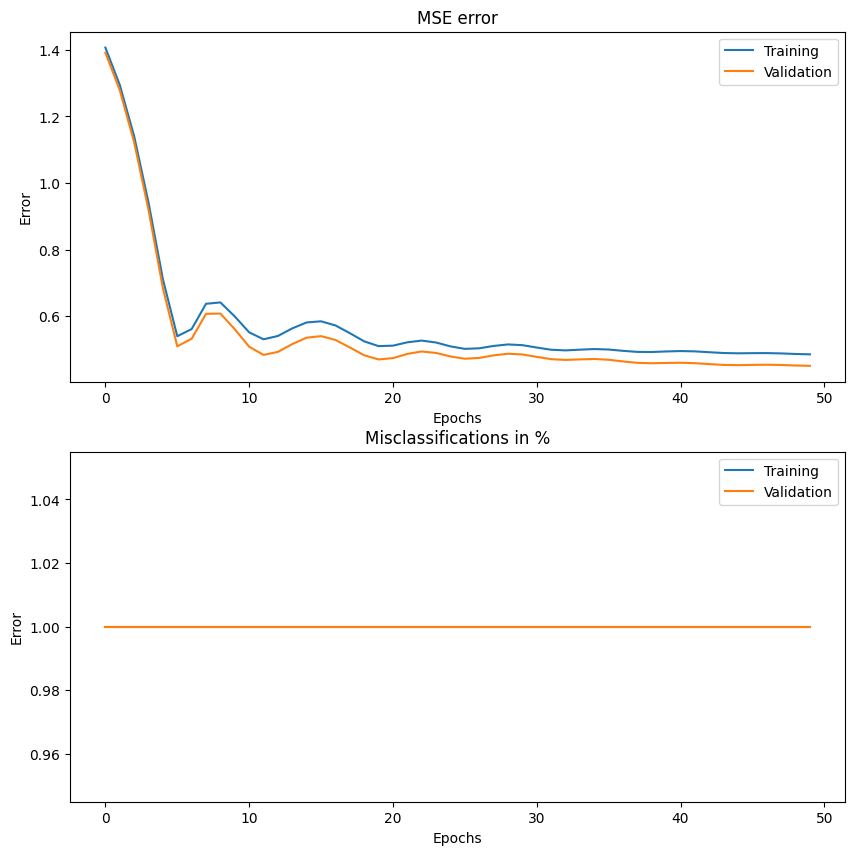

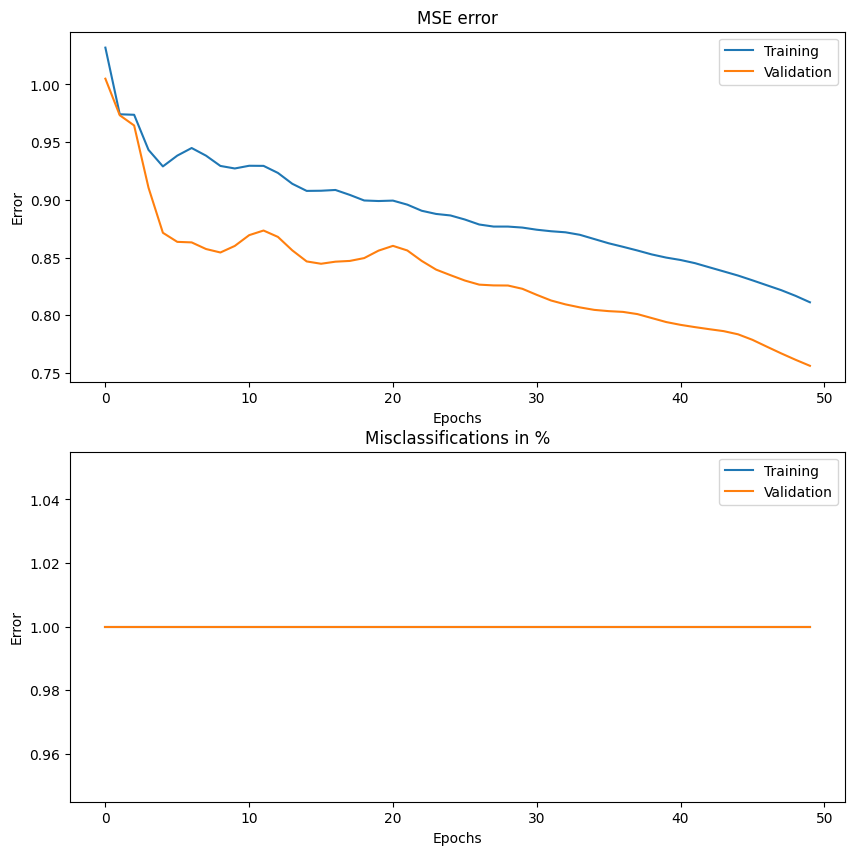

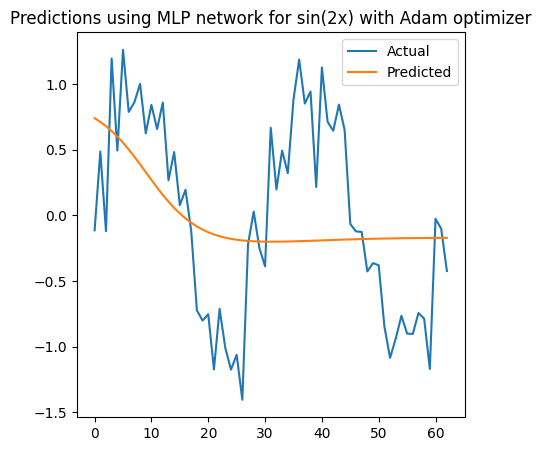

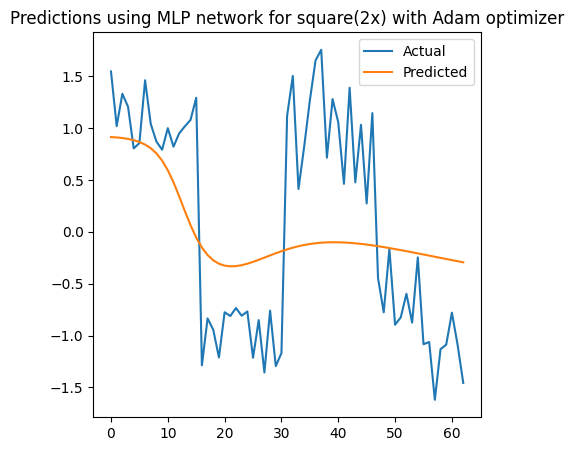

In [23]:
import torch.optim as optim
import tqdm
import time

# Predictions using least square methods on noised data
plot_predictions(X_test, [noised_sin_Y_test, noised_square_Y_test], [noised_sin_ls_Y_pred, noised_square_ls_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using least square method", centers_nb)

# Single hidden layer perceptron


class TwoLayerPerceptron():
    def __init__(self, train_patterns: torch.Tensor, train_targets: torch.Tensor, val_patterns: torch.Tensor, val_targets: torch.Tensor, n_hidden: int, n_epochs: int, eta: float, alpha: float):
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        self.n_output = 1
        self.n_input = 2

        self.eta = eta
        self.alpha = alpha

        self.w = torch.randn(n_hidden, self.n_input+1, requires_grad=True)
        self.v = torch.randn(self.n_output, n_hidden+1, requires_grad=True)
        self.dw = torch.zeros_like(self.w)
        self.dv = torch.zeros_like(self.v)

        self.mse_error_train = np.zeros(n_epochs)
        self.misclassifications_train = np.zeros(n_epochs)
        self.mse_error_val = np.zeros(n_epochs)
        self.misclassifications_val = np.zeros(n_epochs)

        self.train_patterns = train_patterns
        self.train_patterns = torch.cat(
            (self.train_patterns, torch.ones(1, self.train_patterns.shape[1])), dim=0)
        self.val_patterns = val_patterns
        self.val_patterns = torch.cat(
            (self.val_patterns, torch.ones(1, self.val_patterns.shape[1])), dim=0)

        self.train_targets = train_targets
        self.val_targets = val_targets

        self.optimizer = optim.Adam([self.w, self.v], lr=eta, betas=(
            0.9, 0.999))  # Using Adam optimizer

    def weight_update(self, delta_o: torch.Tensor, delta_h: torch.Tensor, h_out: torch.Tensor, patterns: torch.Tensor, w: torch.Tensor, v: torch.Tensor, dw: torch.Tensor, dv: torch.Tensor, alpha: float, eta: float) -> torch.Tensor:
        dw = (dw * alpha) - (delta_h @ patterns.T) * (1-alpha)
        dv = (dv * alpha) - (delta_o @ h_out.T) * (1-alpha)
        w = w + dw * eta
        v = v + dv * eta
        return w, v, dw, dv

    def backward_pass(self, out: torch.Tensor, targets: torch.Tensor, h_out: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        delta_o = (out - targets) * self.phi_prime(out)
        delta_h = (v.T @ delta_o) * self.phi_prime(h_out)
        delta_h = delta_h[:-1, :]
        return delta_o, delta_h

    def forward_pass(self, patterns: torch.Tensor, w: torch.Tensor, v: torch.Tensor) -> torch.Tensor:
        h = w @ patterns
        h_out = self.phi(h)
        h_out = torch.cat((h_out, torch.ones(1, patterns.shape[1])), dim=0)
        o = v @ h_out
        out = self.phi(o)
        return out, h_out

    def phi(self, x: torch.Tensor) -> torch.Tensor:
        return 2/(1+torch.exp(-x))-1

    def phi_prime(self, phi_x: torch.Tensor) -> torch.Tensor:
        return 0.5*(1+phi_x)*(1-phi_x)

    def visualize_data(self):
        plt.figure()
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == 1],
                 self.train_patterns[1, self.train_targets[0, :] == 1], 'o')
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == -1],
                 self.train_patterns[1, self.train_targets[0, :] == -1], 'o')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Class A', 'Class B'])
        plt.title('Data')
        plt.show()

    def train(self):
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            out, h_out = self.forward_pass(self.train_patterns, self.w, self.v)
            val, _ = self.forward_pass(self.val_patterns, self.w, self.v)

            self.mse_error_train[epoch] = torch.mean(
                (out - self.train_targets)**2)
            self.misclassifications_train[epoch] = torch.sum(torch.sign(
                out) != self.train_targets)/(self.train_targets.shape[1])
            self.mse_error_val[epoch] = torch.mean((val - self.val_targets)**2)
            self.misclassifications_val[epoch] = torch.sum(
                torch.sign(val) != self.val_targets)/(self.val_targets.shape[1])

            delta_o, delta_h = self.backward_pass(
                out, self.train_targets, h_out, self.v)
            self.w, self.v, self.dw, self.dv = self.weight_update(
                delta_o, delta_h, h_out, self.train_patterns, self.w, self.v, self.dw, self.dv, self.alpha, self.eta)
        return self.w, self.v

    def train_sequential(self):
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            outs = []
            h_outs = []
            for i in range(self.train_patterns.shape[1]):
                out, h_out = self.forward_pass(
                    self.train_patterns[:, i].reshape(-1, 1), self.w, self.v)
                outs.append(out)
                h_outs.append(h_out)
                delta_o, delta_h = self.backward_pass(
                    out, self.train_targets[:, i].reshape(-1, 1), h_out, self.v)
                self.w, self.v, self.dw, self.dv = self.weight_update(
                    delta_o, delta_h, h_out, self.train_patterns[:, i].reshape(-1, 1), self.w, self.v, self.dw, self.dv, self.alpha, self.eta)
            out = torch.cat(outs, dim=1)
            h_out = torch.cat(h_outs, dim=1)
            val, _ = self.forward_pass(self.val_patterns, self.w, self.v)

            self.mse_error_train[epoch] = torch.mean(
                (out - self.train_targets)**2)
            self.misclassifications_train[epoch] = torch.sum(torch.sign(
                out) != self.train_targets)/(self.train_targets.shape[1])
            self.mse_error_val[epoch] = torch.mean((val - self.val_targets)**2)
            self.misclassifications_val[epoch] = torch.sum(
                torch.sign(val) != self.val_targets)/(self.val_targets.shape[1])
        return self.w, self.v

    def train_adam(self):
        for epoch in tqdm.tqdm(range(self.n_epochs)):
            out, h_out = self.forward_pass(self.train_patterns, self.w, self.v)
            val, _ = self.forward_pass(self.val_patterns, self.w, self.v)

            self.mse_error_train[epoch] = torch.mean(
                (out - self.train_targets) ** 2)
            self.misclassifications_train[epoch] = torch.sum(torch.sign(
                out) != self.train_targets) / (self.train_targets.shape[1])
            self.mse_error_val[epoch] = torch.mean(
                (val - self.val_targets) ** 2)
            self.misclassifications_val[epoch] = torch.sum(torch.sign(
                val) != self.val_targets) / (self.val_targets.shape[1])

            delta_o, delta_h = self.backward_pass(
                out, self.train_targets, h_out, self.v)

            self.optimizer.zero_grad()
            out.backward(delta_o)
            self.optimizer.step()
        return self.w, self.v

    def predict(self, pattern):
        pattern = torch.cat((pattern, torch.ones(1, pattern.shape[1])), dim=0)
        out, _ = self.forward_pass(pattern, self.w, self.v)
        return out

    def visualize_error(self):
        fig, axs = plt.subplots(2, figsize=(10, 10))
        axs[0].plot(self.mse_error_train)
        axs[0].plot(self.mse_error_val)
        axs[0].set_title('MSE error')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Error')
        axs[0].legend(['Training', 'Validation'])
        axs[1].plot(self.misclassifications_train)
        axs[1].plot(self.misclassifications_val)
        axs[1].set_title('Misclassifications in %')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Error')
        axs[1].legend(['Training', 'Validation'])
        plt.show()

    def visualize_decision_boundary(self):
        x = torch.linspace(-1.5, 2, 100)
        y = torch.linspace(-1.3, 1, 100)
        X, Y = torch.meshgrid(x, y)
        Z = torch.zeros_like(X)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j] = self.predict(torch.tensor([[X[i, j]], [Y[i, j]]]))
        plt.figure()
        X = X.detach().numpy()
        Y = Y.detach().numpy()
        Z = Z.detach().numpy()
        plt.contourf(X, Y, Z, levels=5)
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == 1],
                 self.train_patterns[1, self.train_targets[0, :] == 1], 'o')
        plt.plot(self.train_patterns[0, self.train_targets[0, :] == -1],
                 self.train_patterns[1, self.train_targets[0, :] == -1], 'o')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(['Class A', 'Class B'], loc='lower left')
        plt.title(
            f'Decision boundary for a two-layer perceptron with {self.n_hidden} hidden nodes')
        plt.show()


train_patterns = X_train.clone()
train_targets_sin = noised_sin_Y_train.clone()
train_targets_square = noised_square_Y_train.clone()
val_patterns = X_test.clone()
val_targets_sin = noised_sin_Y_test.clone()
val_targets_square = noised_square_Y_test.clone()


def reshape_data(L):
    return torch.reshape(L, (1, L.shape[0]))


train_patterns = reshape_data(train_patterns)
train_targets_sin = reshape_data(train_targets_sin)
train_targets_square = reshape_data(train_targets_square)
val_patterns = reshape_data(val_patterns)
val_targets_sin = reshape_data(val_targets_sin)
val_targets_square = reshape_data(val_targets_square)

train_patterns = torch.cat(
    (train_patterns, torch.ones(1, train_patterns.shape[1])), dim=0)
val_patterns = torch.cat(
    (val_patterns, torch.ones(1, val_patterns.shape[1])), dim=0)

mlp_model_sin = TwoLayerPerceptron(train_patterns, train_targets_sin, val_patterns,
                                   val_targets_sin, n_hidden=centers_nb, n_epochs=epochs, eta=0.05, alpha=0.9)
mlp_model_square = TwoLayerPerceptron(train_patterns, train_targets_square, val_patterns,
                                      val_targets_square, n_hidden=centers_nb, n_epochs=epochs, eta=0.05, alpha=0.9)

start = time.time()
mlp_model_sin.train_adam()
print('Time to train sin(2x) model: ', time.time()-start)

start = time.time()
mlp_model_square.train_adam()
print('Time to train square(2x) model: ', time.time()-start)
mlp_model_sin.visualize_error()
mlp_model_square.visualize_error()


def plot_predictions_mlp(model, X_test, Y_test, title):
    # Plot predictions
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # Prediction from X_test
    y_pred_mlp = model.predict(X_test)

    y_pred_mlp = y_pred_mlp.detach().numpy()
    y_pred_mlp = np.reshape(y_pred_mlp, (y_pred_mlp.shape[1],))

    ax.plot(Y_test, label='Actual')
    ax.plot(y_pred_mlp, label='Predicted')
    ax.set_title(title)
    ax.legend()

    plt.show()


plot_predictions_mlp(mlp_model_sin, val_patterns, noised_sin_Y_test,
                     "Predictions using MLP network for sin(2x) with Adam optimizer")
plot_predictions_mlp(mlp_model_square, val_patterns, noised_square_Y_test,
                     "Predictions using MLP network for square(2x) with Adam optimizer")

## Competitive learning to initialise RBF units


In [24]:
def competitive_learning_centers(centers, X_train, lr, epochs):
    for epoch in range(epochs):
        # choose a random pattern
        i = np.random.randint(X_train.shape[0])
        x = X_train[i]
        # calculate the distance to each center
        distances = torch.sum((centers - x)**2, dim=-1)
        # find the winner
        winner = torch.argmin(distances)
        # update the winner
        centers[winner] = centers[winner] + lr * (x - centers[winner])
    return centers

In [25]:
best_3_1_sigma = 0.1
best_3_1_center_nb_classify = 22

In [26]:
# Function that allows to train for the two target functions and return key results
def train_ls_target_cl(X_train, sin_Y_train, square_Y_train, X_test, centers_nb, sigma_value):
    # Generate centers
    centers_sin = torch.linspace(0, 2*np.pi, centers_nb[0])
    sigmas_sin = torch.tensor([sigma_value[0]]*centers_sin.shape[0])
    centers_square = torch.linspace(0, 2*np.pi, centers_nb[1])
    sigmas_square = torch.tensor([sigma_value[1]]*centers_square.shape[0])

    centers_sin = competitive_learning_centers(centers_sin, X_train, 0.1, 1000)
    centers_square = competitive_learning_centers(
        centers_square, X_train, 0.1, 1000)

    # Training the models
    # Model that approximates sin(2x)
    sin_model = RBFNet(centers_sin, sigmas_sin)
    sin_weights = sin_model.least_squares_train(X_train, sin_Y_train)

    # Model that approximates square(2x)
    square_model = RBFNet(centers_square, sigmas_square)
    square_weights = square_model.least_squares_train(X_train, square_Y_train)

    # Predict
    sin_Y_pred = sin_model.predict(X_test)
    square_Y_pred = square_model.predict(X_test)

    return sin_model, sin_weights, sin_Y_pred, square_model, square_weights, square_Y_pred

# Function that allows to train for the two target functions and return key results
def train_delta_target_cl(X_train, sin_Y_train, square_Y_train, X_test, centers_nb, sigma_value, lr=0.01, nb_epochs=50):
    # Generate centers
    centers_sin = torch.linspace(0, 2*np.pi, centers_nb[0])
    sigmas_sin = torch.tensor([sigma_value[0]]*centers_sin.shape[0])
    centers_square = torch.linspace(0, 2*np.pi, centers_nb[1])
    sigmas_square = torch.tensor([sigma_value[1]]*centers_square.shape[0])

    centers_sin = competitive_learning_centers(centers_sin, X_train, 0.1, 1000)
    centers_square = competitive_learning_centers(centers_square, X_train, 0.1, 1000)

    # Training the models
    # Model that approximates sin(2x)
    sin_model = RBFNet(centers_sin, sigmas_sin)
    sin_weights, sin_loss = sin_model.delta_train(
        X_train, sin_Y_train, lr, nb_epochs)

    # Model that approximates square(2x)
    square_model = RBFNet(centers_square, sigmas_square)
    square_weights, square_loss = square_model.delta_train(
        X_train, square_Y_train, lr, nb_epochs)

    # Predict
    sin_Y_pred = sin_model.predict(X_test)
    square_Y_pred = square_model.predict(X_test)

    return sin_model, sin_weights, torch.tensor(sin_loss), sin_Y_pred, square_model, square_weights, torch.tensor(square_loss), square_Y_pred

In [27]:
best_sigma_sin_ls = 0.1
best_sigma_sin_delta = 0.5
best_center_nb_sin_ls = 45
best_center_nb_sin_delta = 37

best_sigma_square_ls = 0.1
best_sigma_square_delta = 0.07
best_center_nb_square_ls = 45
best_center_nb_square_delta = 45

sigma_value_ls = (best_sigma_sin_ls, best_sigma_square_ls)
sigma_value_delta = (best_sigma_sin_delta, best_sigma_square_delta)

centers_nb_ls = (best_center_nb_sin_ls, best_center_nb_square_ls)
centers_nb_delta = (best_center_nb_sin_delta, best_center_nb_square_delta)

sin_ls_model, sin_ls_weights, sin_ls_Y_pred, square_ls_model, square_ls_weights, square_ls_Y_pred = train_ls_target_cl(
    X_train, sin_Y_train, square_Y_train, X_test, centers_nb_ls, sigma_value_ls)
sin_delta_model, sin_delta_weights, sin_delta_loss, sin_delta_Y_pred, square_delta_model, square_delta_weights, square_delta_loss, square_delta_Y_pred = train_delta_target_cl(
    X_train, sin_Y_train, square_Y_train, X_test, centers_nb_delta, sigma_value_delta, lr=0.01, nb_epochs=100)

Training time :  0.00021409988403320312
Training time :  0.00022721290588378906


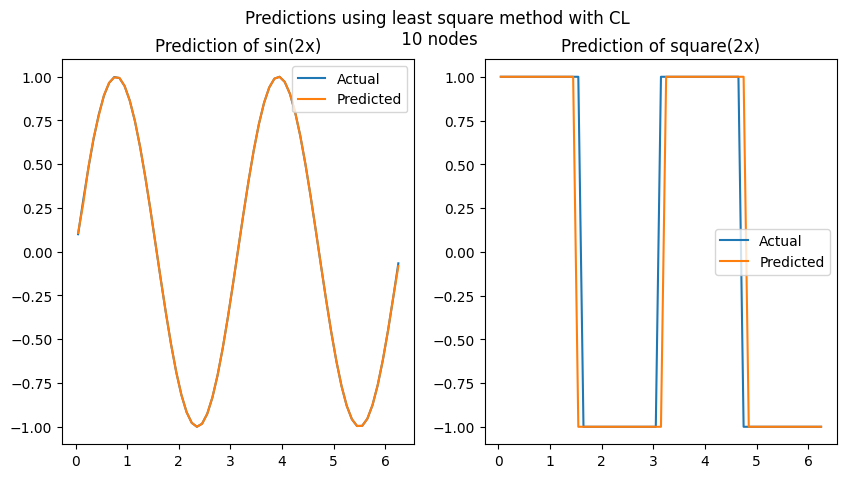

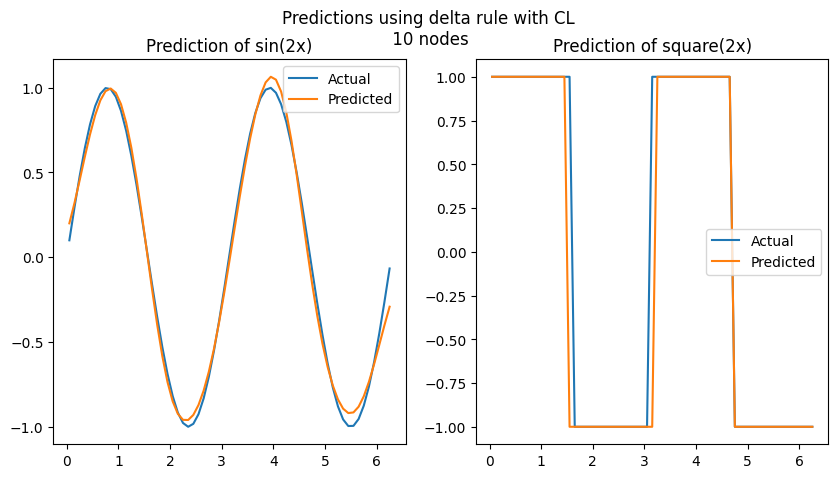

In [28]:
plot_predictions(X_test, [sin_Y_test, square_Y_test], [sin_ls_Y_pred, classify(square_ls_Y_pred)], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions using least square method with CL", centers_nb)
plot_predictions(X_test, [sin_Y_test, square_Y_test], [sin_delta_Y_pred, classify(square_delta_Y_pred)], [
                    "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions using delta rule with CL", centers_nb)

In [29]:
# Set parameters
lr = 0.1
epochs = 100

# Training the models
sin_delta_model, sin_delta_weights, sin_delta_loss, noised_sin_delta_Y_pred, square_delta_model, square_delta_weights, square_delta_loss, noised_square_delta_Y_pred = train_delta_target_cl(
    X_train, noised_sin_Y_train, noised_square_Y_train, X_test, centers_nb_delta, sigma_value_delta, lr, epochs)
sin_noised_ls_model, sin_noised_ls_weights, noised_sin_ls_Y_pred, square_noised_ls_model, square_noised_ls_weights, noised_square_ls_Y_pred = train_ls_target_cl(
    X_train, noised_sin_Y_train, noised_square_Y_train, X_test, centers_nb_ls, sigma_value_ls)

Training time :  0.00016617774963378906
Training time :  0.0002238750457763672


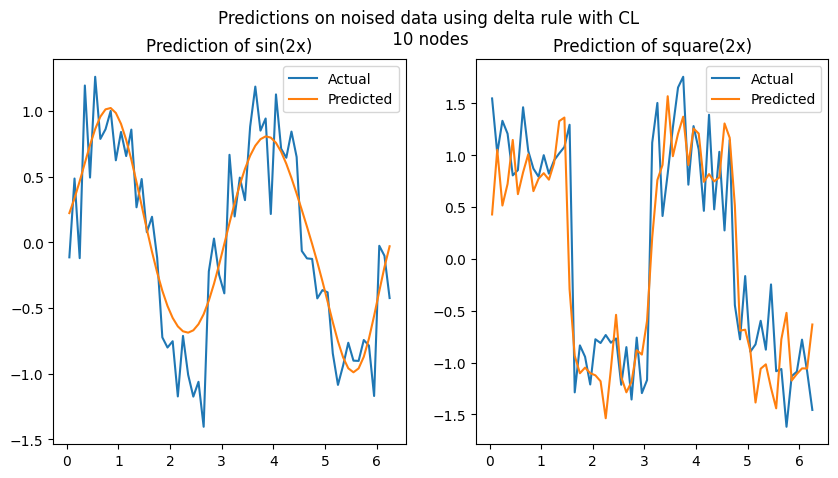

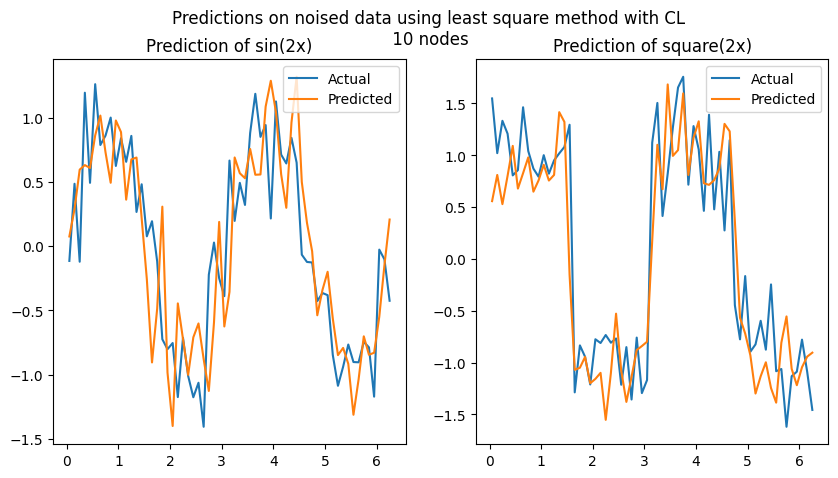

In [30]:
# Predictions using delta rule on noised data
plot_predictions(X_test, [noised_sin_Y_test, noised_square_Y_test], [noised_sin_delta_Y_pred, noised_square_delta_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using delta rule with CL", centers_nb)

# Predictions using least square methods on noised data
plot_predictions(X_test, [noised_sin_Y_test, noised_square_Y_test], [noised_sin_ls_Y_pred, noised_square_ls_Y_pred], [
                 "Prediction of sin(2x)", "Prediction of square(2x)"], "Predictions on noised data using least square method with CL", centers_nb)

# 2D training on ballist

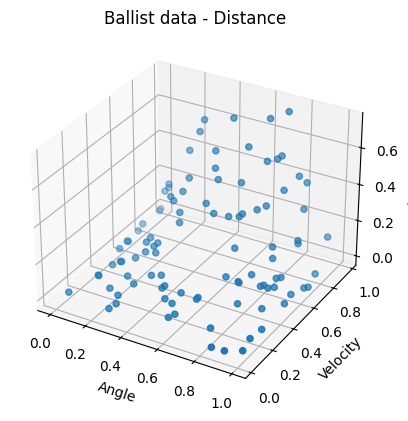

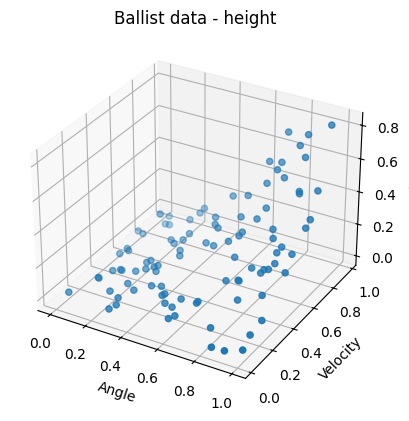

In [31]:
# load ballist as training set, balltest as test set, 2 dimension input and 2 dimension output
X_train_full = np.loadtxt('ballist.dat')
X_test_full = np.loadtxt('balltest.dat')

# split the data into input and output
X_train = torch.tensor(X_train_full[:, 0:2])
Y_train = torch.tensor(X_train_full[:, 2:])
X_test = torch.tensor(X_test_full[:, 0:2])
Y_test = torch.tensor(X_test_full[:, 2:])

# Make 3D plot with X_train[:, 0], X_train[:, 1], Y_train[:, 0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], Y_train[:, 0])
ax.set_xlabel('Angle')
ax.set_ylabel('Velocity')
ax.set_zlabel('Distance')
plt.title('Ballist data - Distance')
plt.show()

# Make 3D plot with X_train[:, 0], X_train[:, 1], Y_train[:, 0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:, 0], X_train[:, 1], Y_train[:, 1])
ax.set_xlabel('Angle')
ax.set_ylabel('Velocity')
ax.set_zlabel('Height')
plt.title('Ballist data - height')
plt.show()



In [32]:
class RBFNet():
    def __init__(self, centers, sigma, input_dim = 1, output_dim = 1):
        # dimensions
        self.input_dim = input_dim
        self.hidden_dim = centers.shape[0]
        self.output_dim = output_dim

        # hyperparemeters
        self.centers = centers
        self.sigma = sigma

        # parameters of training
        self.w = torch.zeros(self.output_dim, self.hidden_dim)
        self.loss_train = []
        self.loss_val = []

    # Kernel using gaussian RBF
    def phi(self, x):
        phi = []
        for center in self.centers :
            phi.append(torch.exp(-torch.norm(x-center,2)**2 /(2*self.sigma**2)).item())
        return torch.tensor(phi)

    
    # MSE loss
    def loss(self, y_pred, y):
        y = y.view_as(y_pred)
        return torch.mean((y-y_pred)**2)
    
    def get_std(self, y_pred, y) :
        y = y.view_as(y_pred)
        return torch.std(y_pred-y)
    
    # Residual value
    def residual_value(self, y_pred, y) :
        y = y.view_as(y_pred)
        return torch.mean(torch.abs(y_pred - y))
    
    # Forward method
    def forward(self, x):
        return self.phi(x) @ self.w.T
    
    # 1. Training method : least squares
    def least_squares_train(self, X_train, Y_train):
        start_time = time.time()

        # resetting the value of the weights
        self.w = torch.zeros(self.output_dim, self.hidden_dim)

        phi_matrix = self.phi(X_train)
        self.w = (torch.inverse(phi_matrix.T @ phi_matrix)) @ (Y_train @ phi_matrix)

        end_time = time.time()
        print("Training time : ", end_time - start_time)
        return self.w

    ### Shuffling of the data
    def shuffle_dataset(self, X, Y):
        indices = torch.randperm(X.shape[0])
        shuffled_X = X[indices]
        shuffled_Y = Y[indices]
        return shuffled_X, shuffled_Y

    ### Update rule
    def delta_rule(self, x, y, lr): 
        y_pred = self.forward(x)
        phi_data = self.phi(x)
        
        update1 = (y - y_pred)[0] * phi_data
        update2 = (y - y_pred)[1] * phi_data

        update = torch.stack([update1, update2])
        self.w = self.w + lr * update
        return self.w.reshape(1, -1)
    
    # 2. Training method : delta rule
    def delta_train(self, X_train, Y_train, lr, epochs):
        # resetting the vlues of the weights
        self.w = torch.randn(self.output_dim, self.hidden_dim)
        self.loss_train = []
        
        for epoch in range(epochs):
            # shuffling data
            X, Y = self.shuffle_dataset(X_train, Y_train)

            for i in range(X.shape[0]):
                self.delta_rule(X[i], Y[i], lr)

            #self.loss_train.append(self.loss(self.forward(X), Y))
                    
        return self.w, self.loss_train
    
    def predict(self, x):
        n = x.shape[0]
        result = torch.zeros(x.shape)
        for i in range(n) :
            result[i] = self.forward(x[i])
        return result

    



In [44]:
# Training the models
centers_nb = 50
centers = torch.cat((torch.linspace(0, 1, centers_nb).reshape(-1, 1), torch.linspace(0, 1, centers_nb).reshape(-1, 1)), dim=1)
sigma_value = 0.3
nb_epochs = 100
centers = competitive_learning_centers(
    centers, X_train, 0.1, 1000)

rbf_2d_distance = RBFNet(centers, sigma_value, 2, 2)

# train the model using delta rule
rbf_2d_distance.delta_train(X_train, Y_train, 0.01, nb_epochs)


(tensor([[-1.4187e+00,  5.7075e-01, -1.1152e-01, -1.2964e+00,  8.6094e-01,
          -8.6786e-01,  1.7812e+00,  1.5612e+00, -1.7369e-01,  2.0018e-01,
          -7.9789e-02,  7.8040e-01,  2.4470e-01, -1.2431e+00, -1.4501e+00,
          -1.8966e-01,  8.5943e-01,  1.5944e-03, -1.8022e+00,  4.7840e-01,
          -7.8642e-01, -4.2164e-01,  1.8696e-01,  9.5241e-01,  1.8587e-01,
           2.7070e+00, -6.4818e-01, -4.3877e-01, -2.9186e-01,  6.9390e-01,
          -1.2126e-01, -1.7111e+00, -7.2720e-01, -6.3862e-01,  1.1894e+00,
           1.2994e+00,  7.8819e-01, -1.9781e-02,  1.3548e+00, -8.4858e-01,
          -3.2947e-01,  9.7870e-01, -2.0894e+00, -6.8778e-01, -1.0192e+00,
           4.7357e-02,  9.2620e-02,  1.2876e+00,  7.8167e-01,  2.7736e-02],
         [ 8.3793e-01, -9.1560e-01, -1.5141e+00, -1.3999e-01,  8.9347e-01,
           8.4513e-01,  3.1826e-01, -8.7167e-01, -1.5109e-01,  1.2348e-01,
          -1.3364e-01,  9.4346e-02,  1.4766e+00,  1.8796e-01,  3.6732e-01,
          -4.3933e-02, -

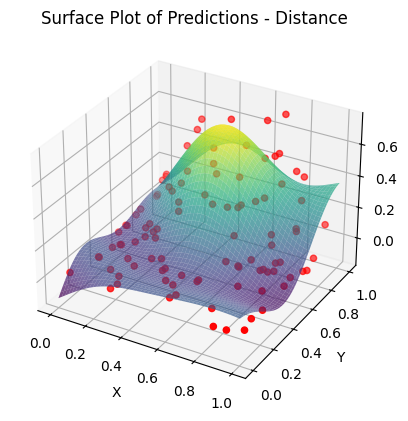

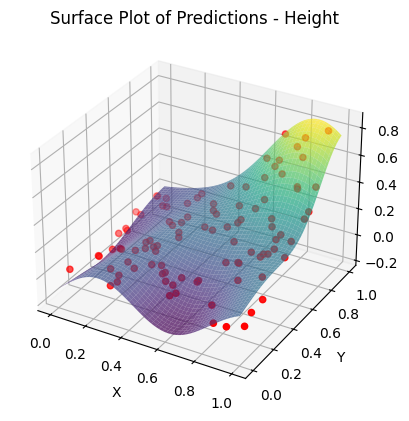

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate input data for the surface plot
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z_pred = rbf_2d_distance.predict(torch.tensor(np.c_[X.ravel(), Y.ravel()]))

# Reshape the predictions to match the shape of X and Y
Z_pred = Z_pred[:, 0].reshape(X.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.7)
ax.scatter(X_train[:, 0], X_train[:, 1], Y_train[:, 0], color='r')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Surface Plot of Predictions - Distance')

# Show the plot
plt.show()

# Generate input data for the surface plot
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
Z_pred = rbf_2d_distance.predict(torch.tensor(np.c_[X.ravel(), Y.ravel()]))

# Reshape the predictions to match the shape of X and Y
Z_pred = Z_pred[:, 1].reshape(X.shape)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_pred, cmap='viridis', alpha=0.7)
ax.scatter(X_train[:, 0], X_train[:, 1], Y_train[:, 1], color='r')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Surface Plot of Predictions - Height')

# Show the plot
plt.show()